In [ ]:
!unzip '/content/drive/MyDrive/Screenshots90k.zip' -d '/content/'

In [2]:
import numpy as np
import os
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import tensorflow.keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [3]:
actions = ['left', 'shoot', 'right', 'nomove']
action_label = {actions:i for i, actions in enumerate(actions)}
IMAGE_SIZE = (224, 224)

In [4]:
output_folder = "/content/Screenshots"

model_path = "/content/drive/MyDrive"

In [ ]:
#import shutil

#shutil.rmtree(output_folder + '/train/nomove')
#shutil.rmtree(output_folder + '/val/nomove')

In [5]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(output_folder,
                                                                                           batch_size=32,
                                                                                           labels='inferred',
                                                                                           label_mode='categorical',
                                                                                           image_size=IMAGE_SIZE,
                                                                                           validation_split=0.2,
                                                                                           subset="training",
                                                                                           shuffle=True,
                                                                                           seed = 62345)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(output_folder,
                                                                                           batch_size=32,
                                                                                           labels='inferred',
                                                                                           label_mode='categorical',
                                                                                           image_size=IMAGE_SIZE,
                                                                                           validation_split=0.2,
                                                                                           subset="validation",
                                                                                           shuffle=True,
                                                                                           seed = 62345)

Found 90416 files belonging to 4 classes.
Using 72333 files for training.
Found 90416 files belonging to 4 classes.
Using 18083 files for validation.


In [6]:
num_images_per_class = []

for label in training_dataset.class_names:
    dir_name = output_folder + '/' +label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
num_images_per_class

[25089, 25505, 24815, 15007]

In [7]:
training_dataset.class_names

['left', 'nomove', 'right', 'shoot']

In [ ]:
sum = np.sum(num_images_per_class)
weights = []
for i in num_images_per_class:
  weights.append(1.17-i/sum)
weights

[0.88735248022743, 0.8935120457775996, 0.8927466559755075, 1.0063888180194627]

In [8]:
training_dataset = training_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
cb = [tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_accuracy',mode='max',restore_best_weights=True), tf.keras.callbacks.ModelCheckpoint("ResNet50V2-01.h5",save_best_only=True)]

# First - AlexNet using Dropout layers

Using SGD optimizer (showing best learning rate after testing)

In [15]:
class AlexNet2SGD(tf.keras.models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(BatchNormalization())
        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dropout(rate = 0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(rate = 0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))
        #self.compile(tf.keras.optimizers.Adam(0.001),
        #            loss='categorical_crossentropy',
        #            metrics=['accuracy'])

In [16]:
model = AlexNet2SGD((224, 224, 3), 4)

In [17]:
model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

cb = [tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)]

In [ ]:
history = model.fit(training_dataset, epochs=100, validation_data=validation_dataset, callbacks=cb, class_weight={0: 1, 1: 1, 2: 1, 3: 1.7})

Epoch 1/100
2261/2261 [==============================] - 132s 58ms/step - loss: 1.5867 - accuracy: 0.2918 - val_loss: 1.3618 - val_accuracy: 0.3386
Epoch 2/100
2261/2261 [==============================] - 125s 55ms/step - loss: 1.5282 - accuracy: 0.3139 - val_loss: 1.3569 - val_accuracy: 0.3434
Epoch 3/100
2261/2261 [==============================] - 125s 55ms/step - loss: 1.5224 - accuracy: 0.3247 - val_loss: 1.3566 - val_accuracy: 0.3369
Epoch 4/100
2261/2261 [==============================] - 126s 56ms/step - loss: 1.5177 - accuracy: 0.3326 - val_loss: 1.3568 - val_accuracy: 0.3446
Epoch 5/100
2261/2261 [==============================] - 126s 56ms/step - loss: 1.5132 - accuracy: 0.3388 - val_loss: 1.3542 - val_accuracy: 0.3402
Epoch 6/100
2261/2261 [==============================] - 125s 55ms/step - loss: 1.5092 - accuracy: 0.3425 - val_loss: 1.3495 - val_accuracy: 0.3479
Epoch 7/100
2261/2261 [==============================] - 129s 57ms/step - loss: 1.5032 - accuracy: 0.3488 - val_

In [ ]:
labels = []
predictions = []
for x,y in validation_dataset:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

In [ ]:
import itertools
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

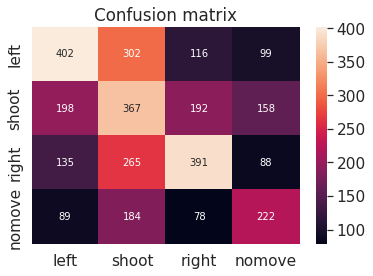

In [ ]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in labels], predictions)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input, decode_predictions
base_model = ResNet50V2(include_top=False)
base_model.trainable = False

model = Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      Dense(256,activation='relu'),
      BatchNormalization(),
      Dense(164,activation='relu'),
      BatchNormalization(),
      Dense(4,activation='sigmoid')
])

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


#cb = [tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_accuracy',mode='max',restore_best_weights=True), tf.keras.callbacks.ModelCheckpoint("ResNet50V2-01.h5",save_best_only=True)]

In [ ]:
history = model.fit(training_dataset, epochs=100, validation_data=validation_dataset, callbacks=cb, class_weight={0: 1, 1: 1, 2: 1, 3: 1.7})

Epoch 1/100
686/686 [==============================] - 85s 117ms/step - loss: 1.6798 - accuracy: 0.2802 - val_loss: 1.5038 - val_accuracy: 0.3051
Epoch 2/100
686/686 [==============================] - 78s 114ms/step - loss: 1.5445 - accuracy: 0.3219 - val_loss: 1.5660 - val_accuracy: 0.2546
Epoch 3/100
686/686 [==============================] - 78s 114ms/step - loss: 1.5078 - accuracy: 0.3492 - val_loss: 1.3868 - val_accuracy: 0.3322
Epoch 4/100
686/686 [==============================] - 78s 113ms/step - loss: 1.4799 - accuracy: 0.3674 - val_loss: 1.4360 - val_accuracy: 0.3270
Epoch 5/100
686/686 [==============================] - 78s 113ms/step - loss: 1.4635 - accuracy: 0.3776 - val_loss: 1.5727 - val_accuracy: 0.2732
Epoch 6/100
686/686 [==============================] - 78s 113ms/step - loss: 1.4418 - accuracy: 0.3897 - val_loss: 1.5006 - val_accuracy: 0.2969
Epoch 7/100
686/686 [==============================] - 78s 114ms/step - loss: 1.4234 - accuracy: 0.4090 - val_loss: 1.4271 -

In [ ]:
class AlexNet2SGD(tf.keras.models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(BatchNormalization())
        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dropout(rate = 0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(rate = 0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
        #self.compile(tf.keras.optimizers.Adam(0.001),
        #            loss='categorical_crossentropy',
        #            metrics=['accuracy'])

In [ ]:
model = AlexNet2SGD((224, 224, 3), 4)

In [ ]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=100, validation_data=(test_images, test_labels), callbacks=[callback])

Epoch 1/100
540/540 [==============================] - 34s 46ms/step - loss: 1.5551 - accuracy: 0.2938 - val_loss: 1.3660 - val_accuracy: 0.3263
Epoch 2/100
540/540 [==============================] - 24s 44ms/step - loss: 1.3739 - accuracy: 0.3236 - val_loss: 1.3553 - val_accuracy: 0.3460
Epoch 3/100
540/540 [==============================] - 24s 44ms/step - loss: 1.3601 - accuracy: 0.3376 - val_loss: 1.3492 - val_accuracy: 0.3518
Epoch 4/100
540/540 [==============================] - 24s 44ms/step - loss: 1.3553 - accuracy: 0.3412 - val_loss: 1.3445 - val_accuracy: 0.3587
Epoch 5/100
540/540 [==============================] - 24s 44ms/step - loss: 1.3496 - accuracy: 0.3492 - val_loss: 1.3414 - val_accuracy: 0.3580
Epoch 6/100
540/540 [==============================] - 24s 44ms/step - loss: 1.3435 - accuracy: 0.3574 - val_loss: 1.3360 - val_accuracy: 0.3742
Epoch 7/100
540/540 [==============================] - 24s 44ms/step - loss: 1.3375 - accuracy: 0.3613 - val_loss: 1.3270 - val_ac

In [ ]:
model.save(model_path + "/models/AlexNetSGDDropout3Labels2 7375/")

In [ ]:
pred = model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

136/136 [==============================] - 2s 12ms/step


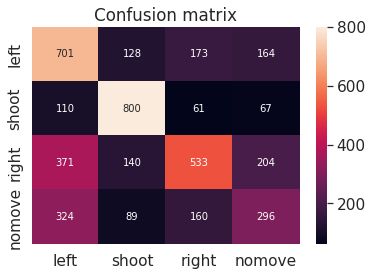

In [ ]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in test_labels], pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()

Using Adam optimizer

In [ ]:
class AlexNet2SGD(tf.keras.models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(BatchNormalization())
        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dropout(rate = 0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(rate = 0.5))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        #self.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001),
        #            loss='categorical_crossentropy',
        #            metrics=['accuracy'])
        self.compile(tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model = AlexNet2SGD((224, 224, 3), 4)

In [ ]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=100, validation_data=(test_images, test_labels), callbacks=[callback])

Epoch 1/100
540/540 [==============================] - ETA: 0s - loss: 2.1997 - accuracy: 0.2864

In [ ]:
model.save(model_path + "/models/AlexNetSGDDropout3Labels2 7375/")

In [ ]:
pred = model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

In [ ]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in test_labels], pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()

# Second - AlexNet without Dropout layers

Using SGD optimizer (showing best learning rate after testing)

In [ ]:
class AlexNetSGD(tf.keras.models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(BatchNormalization())
        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model = AlexNetSGD((224, 224, 3), 4)

In [ ]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=100, validation_data=(test_images, test_labels), callbacks=[callback])

Epoch 1/100
207/207 [==============================] - 14s 60ms/step - loss: 1.6889 - accuracy: 0.3346 - val_loss: 1.3306 - val_accuracy: 0.3722
Epoch 2/100
207/207 [==============================] - 10s 47ms/step - loss: 1.2958 - accuracy: 0.3952 - val_loss: 1.3315 - val_accuracy: 0.3704
Epoch 3/100
207/207 [==============================] - 9s 45ms/step - loss: 1.2597 - accuracy: 0.4218 - val_loss: 1.3439 - val_accuracy: 0.3637
Epoch 4/100
207/207 [==============================] - 9s 44ms/step - loss: 1.2195 - accuracy: 0.4566 - val_loss: 1.3219 - val_accuracy: 0.3813
Epoch 5/100
207/207 [==============================] - 10s 49ms/step - loss: 1.1818 - accuracy: 0.4847 - val_loss: 1.3305 - val_accuracy: 0.3837
Epoch 6/100
207/207 [==============================] - 9s 44ms/step - loss: 1.1426 - accuracy: 0.5118 - val_loss: 1.5532 - val_accuracy: 0.2592
Epoch 7/100
207/207 [==============================] - 9s 44ms/step - loss: 1.1079 - accuracy: 0.5349 - val_loss: 1.3771 - val_accura

In [ ]:
model.save(model_path + "/content/AlexNetSGD/")

In [ ]:
pred = model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

93/93 [==============================] - 1s 12ms/step


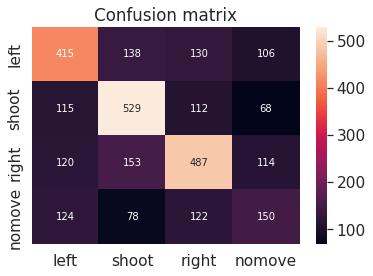

In [ ]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in test_labels], pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()

Using Adam optimizer

In [ ]:
class AlexNetAdam(tf.keras.models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(BatchNormalization())
        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
model = AlexNetAdam((224, 224, 3), 4)

In [ ]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=100, validation_data=(test_images, test_labels), callbacks=[callback])

In [ ]:
model.save(model_path + "/content/AlexNetSGD/")

In [ ]:
pred = model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

42/42 [==============================] - 1s 14ms/step


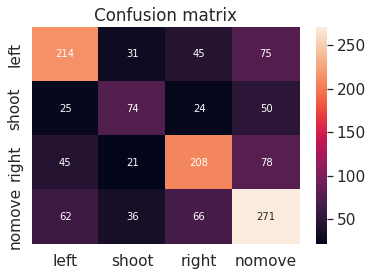

In [ ]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in test_labels], pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()

# Third - Low parameter CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer= tf.keras.optimizers.SGD(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(training_dataset, epochs=100, validation_data=validation_dataset, callbacks=cb, class_weight={0: 1, 1: 1, 2: 1, 3: 1.7})

Epoch 1/100
1721/1721 [==============================] - 86s 49ms/step - loss: 1.6812 - accuracy: 0.2771 - val_loss: 1.3782 - val_accuracy: 0.2940


KeyboardInterrupt: ignored

In [ ]:
model.save(model_path + "/models/AlexNetSGDDropout3Labels2 7375/")

In [ ]:
pred = model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

39/39 [==============================] - 1s 15ms/step


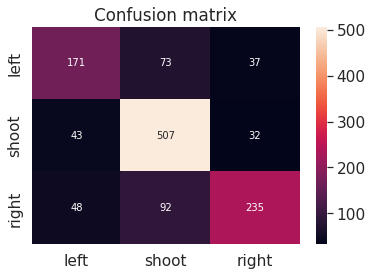

In [ ]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in test_labels], pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()

# VGG16

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4, activation="softmax"))

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
cb = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True), tf.keras.callbacks.ModelCheckpoint("VGG16-01.h5", monitor="val_acc", save_best_only=True)]

In [ ]:
history = model.fit(training_dataset, batch_size=32, epochs=100, validation_data=validation_dataset, callbacks=cb)

Epoch 1/100
686/686 [==============================] - ETA: 0s - loss: 3.1018 - accuracy: 0.2749

686/686 [==============================] - 339s 483ms/step - loss: 3.1018 - accuracy: 0.2749 - val_loss: 1.3628 - val_accuracy: 0.2925
Epoch 2/100
686/686 [==============================] - ETA: 0s - loss: 1.3658 - accuracy: 0.2780

686/686 [==============================] - 320s 467ms/step - loss: 1.3658 - accuracy: 0.2780 - val_loss: 1.3626 - val_accuracy: 0.2925
Epoch 3/100
155/686 [=====>........................] - ETA: 3:48 - loss: 1.3648 - accuracy: 0.2815

KeyboardInterrupt: ignored

In [ ]:
model.save(model_path + "/models/AlexNetSGDDropout3Labels2 7375/")

In [ ]:
pred = model.predict(test_images)
pred_labels = np.argmax(pred, axis=1)

39/39 [==============================] - 1s 15ms/step


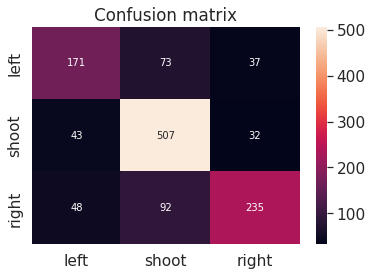

In [ ]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in test_labels], pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
data_generator = ImageDataGenerator()

train_generator = data_generator.flow_from_directory(
        output_folder+"/train",
        target_size=IMAGE_SIZE,
        batch_size=128,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        output_folder+"/val",
        target_size=IMAGE_SIZE,
        batch_size=128,
        class_mode='categorical') 

Found 17275 images belonging to 4 classes.
Found 4321 images belonging to 4 classes.


In [ ]:
def load_dataset():
    
    datasets = [output_folder+"/train", output_folder+"/val"]
    output = []
    
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = action_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                images.append(np.atleast_3d(cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(dataset, folder, file)),cv2.COLOR_BGR2RGB), IMAGE_SIZE)))
                labels.append(label)
        images = np.array(images)
        labels = np.array(labels)
        
        output.append((images, labels))
        
    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_dataset()

Loading /content/datasetCombined/dataset/train


100%|██████████| 4661/4661 [00:30<00:00, 150.52it/s]


Loading /content/datasetCombined/dataset/val


100%|██████████| 1166/1166 [00:07<00:00, 156.80it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=1337)

In [ ]:
train_images.shape

(17275, 224, 224, 3)

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:
def display_random_image(actions, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + actions[labels[index]])
    plt.show()

TypeError: ignored

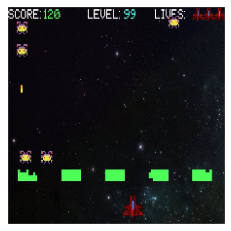

In [ ]:
display_random_image(actions, train_images, train_labels)

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels, 4)
test_labels = tf.keras.utils.to_categorical(test_labels, 4)

In [ ]:
train_generator

In [ ]:
train_labels

array([1, 1, 2, ..., 0, 3, 2])

# Mobilenet

In [9]:
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

model = MobileNet(input_shape=(224, 224, 3), alpha=1., weights=None, classes=4)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

cb = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_10 (DepthwiseConv2D  (None, 14, 14, 512)      4608      
 )                                                               
                                                                 
 conv_dw_10_bn (BatchNormali  (None, 14, 14, 512)      2048      
 zation)  

In [10]:
history = model.fit(training_dataset, epochs=100, validation_data=validation_dataset, callbacks=cb, class_weight={0: 1, 1: 1, 2: 1, 3: 1.7})

Epoch 1/100
2261/2261 [==============================] - 482s 207ms/step - loss: 1.2724 - accuracy: 0.4731 - val_loss: 1.0368 - val_accuracy: 0.5382
Epoch 2/100
2261/2261 [==============================] - 470s 208ms/step - loss: 1.0298 - accuracy: 0.5863 - val_loss: 0.9411 - val_accuracy: 0.5909
Epoch 3/100
2261/2261 [==============================] - 470s 208ms/step - loss: 0.9739 - accuracy: 0.6073 - val_loss: 0.9222 - val_accuracy: 0.6125
Epoch 4/100
2261/2261 [==============================] - 471s 208ms/step - loss: 0.9360 - accuracy: 0.6265 - val_loss: 0.8881 - val_accuracy: 0.6226
Epoch 5/100
2261/2261 [==============================] - 466s 206ms/step - loss: 0.9052 - accuracy: 0.6400 - val_loss: 0.8715 - val_accuracy: 0.6317
Epoch 6/100
2261/2261 [==============================] - 469s 207ms/step - loss: 0.8752 - accuracy: 0.6530 - val_loss: 0.8687 - val_accuracy: 0.6309
Epoch 7/100
2261/2261 [==============================] - 469s 207ms/step - loss: 0.8426 - accuracy: 0.6652

In [11]:
model.save(model_path + "/models/MobileNetAdam90k62acc/")

In [12]:
labels = []
predictions = []
for x,y in validation_dataset:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 0s 446ms/step


In [13]:
import itertools
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

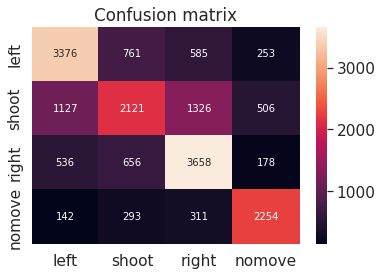

In [14]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in labels], predictions)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()

# EfficientNetB0

In [ ]:
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input

model = EfficientNetB0(input_shape=(224, 224, 3), weights=None, classes=4)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

cb = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 block3a_bn (BatchNormalization  (None, 28, 28, 144)  576        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 28, 28, 144)  0          ['block3a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3a_se_squeeze (GlobalAver  (None, 144)         0           ['block3a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3a_s

In [ ]:
history = model.fit(training_dataset, epochs=100, validation_data=validation_dataset, callbacks=cb, class_weight={0: 1, 1: 1, 2: 1, 3: 1.7})

Epoch 1/100
1721/1721 [==============================] - 569s 325ms/step - loss: 1.7587 - accuracy: 0.3092 - val_loss: 1.2811 - val_accuracy: 0.4577
Epoch 2/100
1721/1721 [==============================] - 551s 320ms/step - loss: 1.2425 - accuracy: 0.4969 - val_loss: 0.9835 - val_accuracy: 0.5806
Epoch 3/100
1721/1721 [==============================] - 557s 324ms/step - loss: 1.0678 - accuracy: 0.5752 - val_loss: 0.9178 - val_accuracy: 0.6036
Epoch 4/100
1721/1721 [==============================] - 556s 323ms/step - loss: 1.0105 - accuracy: 0.5984 - val_loss: 0.9091 - val_accuracy: 0.6004
Epoch 5/100
1721/1721 [==============================] - 556s 323ms/step - loss: 0.9679 - accuracy: 0.6153 - val_loss: 0.8866 - val_accuracy: 0.6278
Epoch 6/100
1721/1721 [==============================] - 550s 320ms/step - loss: 0.9340 - accuracy: 0.6285 - val_loss: 0.9164 - val_accuracy: 0.6227
Epoch 7/100
1721/1721 [==============================] - 558s 324ms/step - loss: 0.8991 - accuracy: 0.6461

In [ ]:
model.save(model_path + "/models/EfficientNetB0Adam68k62/")

In [ ]:
labels = []
predictions = []
for x,y in validation_dataset:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 1s 1s/step


In [ ]:
import itertools
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

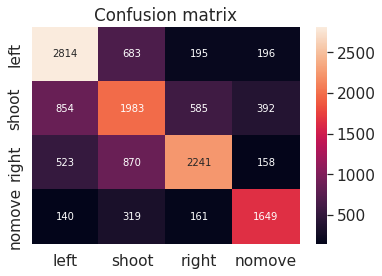

In [ ]:
CM = confusion_matrix([np.argmax(y, axis=None, out=None) for y in labels], predictions)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=actions, 
           yticklabels=actions, ax = ax, fmt='g')
ax.set_title('Confusion matrix')
plt.show()